# Bug Jin_09-11-2020

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [14]:
input_file = "/home/ubuntu/SBstoat/bugs/jin_09-11-2020/Influenza.csv"

In [26]:
# Convert input file to correct format
df_data = pd.read_csv(input_file, header=None)
df_data = df_data.transpose()
df_data.index.name = "time"
name_dct = {p: "P%d" % p for p in range(6)}
df_data = df_data.rename(columns=name_dct)
df_data

,P0,P1,P2,P3,P4,P5
time,,,,,,
0,2.0,1.0,2.5,3.5,2.5,4.0
1,5.5,6.0,5.0,5.5,3.0,5.0
2,4.0,3.0,5.0,6.5,6.5,5.5
3,5.5,1.5,3.0,5.5,6.5,7.5
4,3.0,3.5,5.5,3.5,2.0,5.5
5,0.0,1.3,3.5,4.0,0.8,1.3
6,0.0,0.0,0.0,0.0,0.0,0.0


There are 6 patients with one value to fit. So, there are 6 different fits.

In [28]:
# Influenza, SARS and SARS-CoV3 in Tellurium

### A simple target cell-limited model, T ==> E ==> I --> produce V:
# T - number of target cells
# E - number of exposed cells (virus replicating inside, not yet spreading virus)
# I - number of infected cells (active virus production)
# V - viral titre, in units of TCID50/ml of biofluid wash (for Influenza)

### The ODEs
# dT/dt = - beta*T*V
# dE/dt =   beta*T*V - kappa*E;
# dI/dt =   kappa * E - delta*I;
# dV/dt =   p*y(I) - c*y(V);


import tellurium as te
import SBstoat



ANTIMONY_MODEL  = '''
    // Equations
    E1: T -> E ; beta*T*V ; // Target cells to exposed
    E2: E -> I ; kappa*E ;  // Exposed cells to infected
    E3: -> V ; p*I ;        // Virus production by infected cells
    E4: V -> ; c*V ;        // Virus clearance
    E5: I -> ; delta*I      // Death of infected cells    

    // Parameters - from the Influenza article,
        
    beta = 3.2e-5;  // rate of transition of target(T) to exposed(E) cells, in units of 1/[V] * 1/day
    kappa = 4.0;    // rate of transition from exposed(E) to infected(I) cells, in units of 1/day
    delta = 5.2;    // rate of death of infected cells(I), in units of 1/day
    p = 4.6e-2;     // rate virus(V) producion by infected cells(I), in units of [V]/day
    c = 5.2;        // rate of virus clearance, in units of 1/day

    // Initial conditions
    T = 4E+8 // estimate of the total number of susceptible epithelial cells
             // in upper respiratory tract)
    E = 0
    I = 0
    V = 0.75 // the dose of virus in TCID50 in Influenza experiment; could be V=0 and I = 20 instead for a natural infection

'''


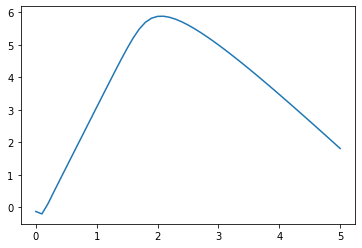

In [33]:
rr = te.loada(ANTIMONY_MODEL)
estimates = rr.simulate()
v_estimate = np.log10(estimates["[V]"])
plt.plot(estimates["time"], v_estimate)

In [27]:
# V vs time (days)


# data section ============================================

# All viral data is in log10(load),...
# log10(load predicted by model) may be needed for data fitting


#Influenza.csv
# Influenza A data - 5 patients
# viral levels in log10(TCID50 / ml of nasal wash)
# time in days since volunteer exposure
# each line in the array is an individual volunteer



#SARS_CoV2_sputum.csv and SARS_CoV2_nasal.csv
# SARS-CoV-2 data - 9 patients,
# for each patient - viral loads from lungs (sputum) and from nasal cavity (swab)
# viral levels in log10(RNA copies / ml sputum), ...
# respectively log10(RNA copies / nasal swab)
# time in days since symptoms onset
# corresponding lines in the two arrays belong to an individual patient



#SARS.csv
# SARS data recorded from 12 patients;
# included them just for comparison, probably too few datapoints for model inference
# viral levels in log10(RNA copies / ml of nasopharingeal aspirate)
# time - only three samples per patient, at 5, 10 and 15 days post symptoms onset

# Fit parameters to ts1
from SBstoat.modelFitter import ModelFitter
fitter = ModelFitter(ANTIMONY_MODEL, input_file, ["beta","kappa","delta","p","c"])
fitter.fitModel()
print(fitter.reportFit())

fitter.plotFitAll(numRow=2, numCol=2)
fitter.plotResiduals(numRow=2, numCol=2)


# Get estimates of parameters
fitter.bootstrap(numIteration=2000, reportInterval=500)
print(fitter.getFittedParameterStds())


ValueError: Must have exactly one time column